# ISIC 2024 Skin Cancer Detection with 3D-TBP | Kaggle
Competition: https://www.kaggle.com/competitions/isic-2024-challenge

## 1. Introduction

fill later

## 2. Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import random
import h5py

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Misc
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Deep Learning Modules...

# Data
df_train = pd.read_csv("train-metadata.csv", dtype={'iddx_5': str, 'mel_mitotic_index': str})
df_test = pd.read_csv("test-metadata.csv", dtype={'iddx_5': str, 'mel_mitotic_index': str})

In [2]:
import torch

## 3. Dataset
Among the most employed initial diagnostic methods is the ABCDE criteria [3,6,7], which are described in Table 1. Nevertheless, while this simple, noninvasive, and expertise-based observational approach often leads to an accurate diagnosis of between **60** and **90% of malignant tumors** [3], there are scenarios where the certainty of cancer’s presence can only be ascertained through a biopsy.

Citation: https://www.mdpi.com/2075-4418/14/4/454

In [3]:
df_train.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [4]:
df_test.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,31.114600,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,68.141071,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,41.358640,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [5]:
# Extremely unbalanced dataset!
# 1: 393 patients
# 0: 400666 patients

# df_train.loc[df_train['target'] == 1]

| Criteria | Indicates | Description |
| --- | --- | --- |
| A | Asymmetry | The majority of illustrated melanomas exhibit an imbalance in their features |
| B | Border | The borders of melanomas are usually uneven and may have irregular or scalloped edges |
| C | Color | The presence of multiple colors within a melanoma is a warning sign |
| D | Diameter | Melanomas tend to be larger, approximately the size of an eraser or around 6 mm in diameter or larger |
| E | Evolution | This considers any alteration in the shape, size, color, or elevation of a skin spot as a warning sign of melanoma |

In [6]:
idx = 1
for column in df_train.columns:
    print(idx, column)
    idx += 1

1 isic_id
2 target
3 patient_id
4 age_approx
5 sex
6 anatom_site_general
7 clin_size_long_diam_mm
8 image_type
9 tbp_tile_type
10 tbp_lv_A
11 tbp_lv_Aext
12 tbp_lv_B
13 tbp_lv_Bext
14 tbp_lv_C
15 tbp_lv_Cext
16 tbp_lv_H
17 tbp_lv_Hext
18 tbp_lv_L
19 tbp_lv_Lext
20 tbp_lv_areaMM2
21 tbp_lv_area_perim_ratio
22 tbp_lv_color_std_mean
23 tbp_lv_deltaA
24 tbp_lv_deltaB
25 tbp_lv_deltaL
26 tbp_lv_deltaLB
27 tbp_lv_deltaLBnorm
28 tbp_lv_eccentricity
29 tbp_lv_location
30 tbp_lv_location_simple
31 tbp_lv_minorAxisMM
32 tbp_lv_nevi_confidence
33 tbp_lv_norm_border
34 tbp_lv_norm_color
35 tbp_lv_perimeterMM
36 tbp_lv_radial_color_std_max
37 tbp_lv_stdL
38 tbp_lv_stdLExt
39 tbp_lv_symm_2axis
40 tbp_lv_symm_2axis_angle
41 tbp_lv_x
42 tbp_lv_y
43 tbp_lv_z
44 attribution
45 copyright_license
46 lesion_id
47 iddx_full
48 iddx_1
49 iddx_2
50 iddx_3
51 iddx_4
52 iddx_5
53 mel_mitotic_index
54 mel_thick_mm
55 tbp_lv_dnn_lesion_confidence


## 4. Exploratory Data Analysis

### 4.1 Disease sex distribution

In [7]:
target_sex_count = df_train.groupby(['target', 'sex']).size()
target_sex_count = pd.DataFrame(target_sex_count).reset_index()
target_sex_count = target_sex_count.rename(columns={'target': "status", 0: 'count'})

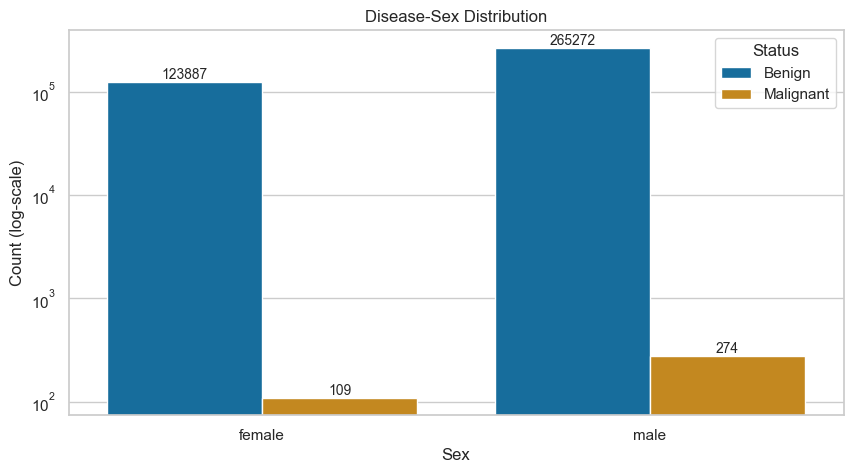

In [8]:
# very large/very small values rep. using log-scale
# resource: https://stackoverflow.com/questions/57722200/how-to-represent-very-large-and-a-very-small-values-in-a-plot
sns.set_theme(style='whitegrid')

fig = plt.figure(figsize=(10,5))
ax = sns.barplot(target_sex_count, x='sex', y='count', hue='status', palette='colorblind', errorbar=None)
ax.set_yscale("log")
_ = ax.set(title='Disease-Sex Distribution',xlabel="Sex", ylabel="Count (log-scale)")

for container in ax.containers:
    ax.bar_label(container, fontsize=10)

ax.legend(title='Status', loc='upper right', labels=['Benign', 'Malignant'])
plt.show()

### 4.2 Age Range Incidence Rates
Note: The Skin Cancer Age Range is an approximation.

Citation/URL: https://www.gentlecure.com/skin-cancer-age-range/#:~:text=Although%20patients%20older%20than%2075,by%20the%20age%20of%2070.

In [9]:
def checkAgeRange(age):
    age = int(age)
    beg_digit = age - 5
    last_digit = age - 1
    return (f"{beg_digit}-{last_digit}")

In [10]:
# Evidence — Based on this data there is weak evidence suggesting adults past 50 y/o 
# are more likely to develop skin cancer.

target_age_approx = df_train.groupby(['target', 'age_approx']).size().to_frame('size').reset_index()
total = target_age_approx['size'].sum()
target_age_approx['percent'] = target_age_approx['size'] / total
target_age_approx['age_range'] = target_age_approx['age_approx'].apply(checkAgeRange)

In [11]:
# target_age_approx

In [12]:
benign = target_age_approx.loc[target_age_approx['target']==0]
malignant = target_age_approx.loc[target_age_approx['target']==1]

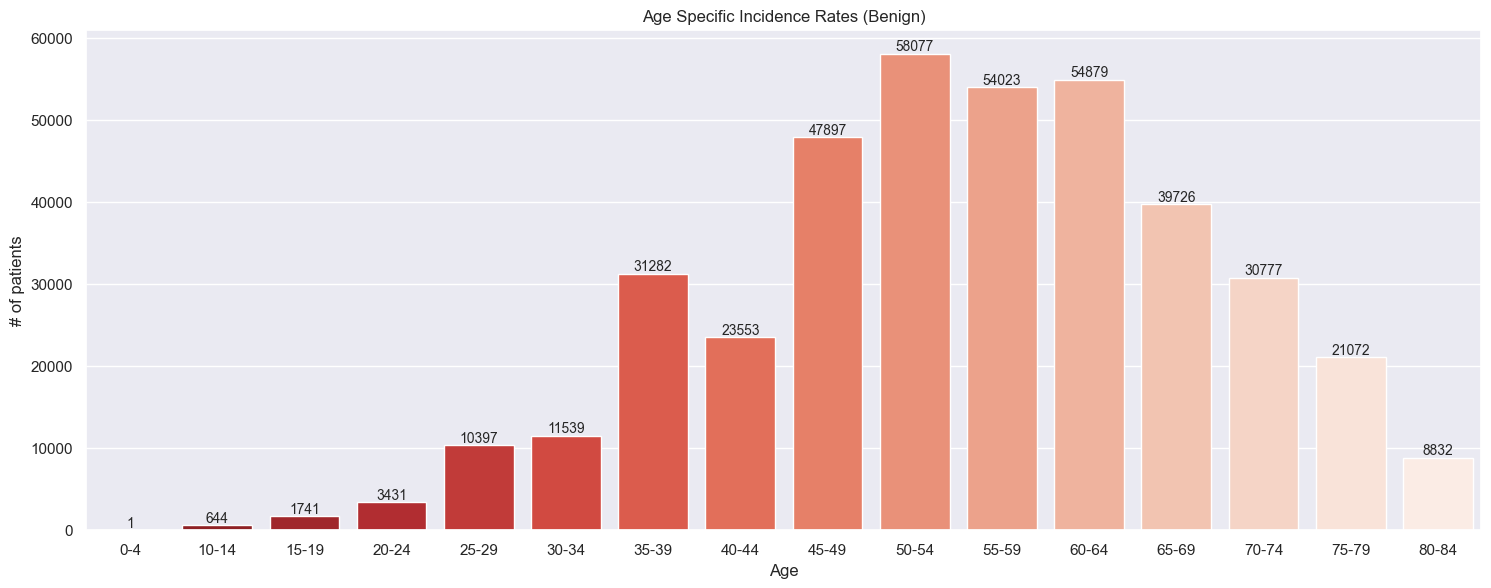

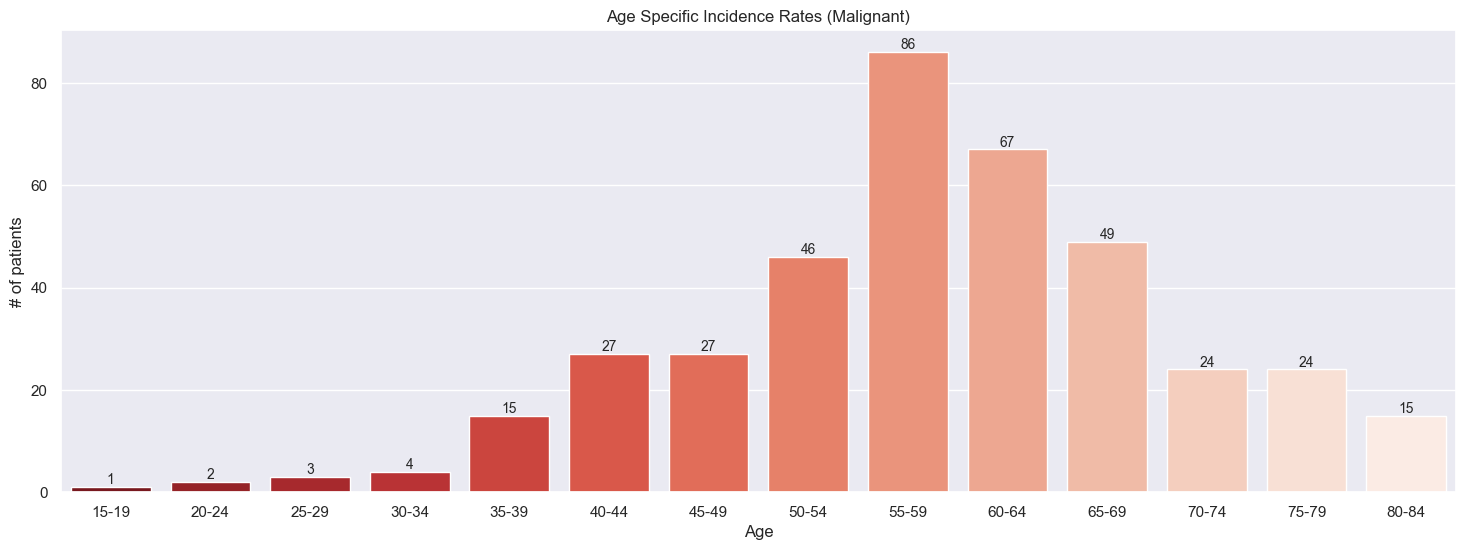

In [13]:
sns.set_theme(style='darkgrid')

# Benign
fig = plt.figure(figsize=(18, 6.5))
ax = sns.barplot(benign, x='age_range', y='size', palette='Reds_r', errorbar='ci')
_ = ax.set(title="Age Specific Incidence Rates (Benign)", xlabel='Age', ylabel='# of patients')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

# Malignant 
fig = plt.figure(figsize=(18, 6))
ax = sns.barplot(malignant, x='age_range', y='size', palette='Reds_r', errorbar='ci')
_ = ax.set(title="Age Specific Incidence Rates (Malignant)", xlabel='Age', ylabel='# of patients')
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

plt.show()

Notes: Look at age range 35-39. consider if the following drop in 40-44 is significant. let us consider how this service would benefit patients in preventive care and triage those who are in at risk. The above barplot showcases the confidence intervals for

In [14]:
df_train['age_range_under50'] = None
df_train.loc[df_train['age_approx']<50, 'age_range_under50'] = True
df_train.loc[df_train['age_approx']>50, 'age_range_under50'] = False
df_train['age_range_under50'].value_counts()

age_range_under50
False    267697
True      82640
Name: count, dtype: int64

In [15]:
age_range_count = df_train.groupby(['target', 'age_range_under50']).size()

In [16]:
age_range_count

target  age_range_under50
0       False                267386
        True                  82588
1       False                   311
        True                     52
dtype: int64

### 4.4 Disease location distribution 

In [17]:
df_train.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,age_range_under50
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,False
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,False
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,False
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,False
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,False


In [18]:
df_train['tbp_lv_location'].value_counts().sum()

401059

In [19]:
df_train['anatom_site_general'].value_counts().sum()

395303

## 5. Image Processing
- Load and normalize the training and test datasets using torchvision.
- Normalization helps get data within a range and reduces the skewness which helps learn faster and better

In [20]:
import torch
import torchvision
from torchvision import transforms

In [ ]:
# create transformation
train_transformation = transforms.Compose([
    # resize image
    transformation
])